# ❄️ ML Goal: Predict Diabetes Dx ❄️ 
This notebook contains methods across Feature Engineering and Modeling

- Demo a few transformations in the Snowpark Preprocessing API. 
- Build a preprocessing pipeline object.
- Build basic, naive binary classifier
- Tune parameters
- Build tuned model
- Serialize and store model and pipeline object in Snowflake Stage

Note: All feature transformations using Snowpark ML are ***distributed operations;*** same as Snowpark DataFrame operations.

# 1. Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import DecimalType

# Snowpark Processing / Encoding
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

# Snowpark Modeling
from snowflake.ml.modeling.ensemble import RandomForestClassifier as RF
from snowflake.ml.modeling.xgboost import XGBClassifier as XGB
from snowflake.ml.modeling.linear_model import LogisticRegression as LR
from snowflake.ml.modeling.model_selection import GridSearchCV

# Snowpark Validation
import snowflake.ml.modeling.metrics as M
from snowflake.ml.modeling.metrics import confusion_matrix as CM

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as SCIKIT_CM

# Misc
import json
import joblib
import cachetools
import os
import io
import sys

# warning suppresion
import warnings; warnings.simplefilter('ignore')

# 2. Secure Snowflake Connection

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [2]:
################################################################################################################
#  You can also use SnowSQL Client to configure connection params: https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()   
#
#  NOTE: If you have named connection params then specify the connection name. Example:
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Create Snowflake Session object
connection_parameters = json.load(open('connection_ds.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

User                        : VCHUNG
Role                        : "ACCOUNTADMIN"
Database                    : "DEMO_DATASCIENCE"
Schema                      : "GOLD"
Warehouse                   : "DEMO_COMPUTE_XSMALL"
Snowflake version           : 8.20.0
Snowpark for Python version : 1.11.1


We will be reading in data from a dynamic table.  
It's a good practice to use DS tools for DS and DE tools for continuous, observable data pipelines. 

Database: DEMO_DATASCIENCE  
Schema: SILVER  
Table: DIABETES  

For more information on loading data, see documentation on [snowflake.snowpark.DataFrameReader](https://docs.snowflake.com/ko/developer-guide/snowpark/reference/python/api/snowflake.snowpark.DataFrameReader.html).




### Data Loading
Two ways to read data in Snowpark. Either **session.table or session.sql**. Code below will walk through both.

#### Session.Table

In [3]:
# Create labels for data location
databaseName = 'DEMO_DATASCIENCE'
schemaName = 'SILVER'
tableName = 'DIABETES'

location = f'{databaseName}.{schemaName}.{tableName}'

# Query Dataframe
dataframe = session.table(location)

dataframe.show()
dataframe.dtypes

----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"  |"PREGNANCIES"  |"GLUCOSE"  |"BLOOD_PRESSURE"  |"HYPERTENSION"  |"SKIN_THICKNESS"  |"INSULIN"  |"BMI"  |"DIABETES_PEDIGREE_FUNCTION"  |"AGE"  |"DIABETES_DX"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1     |6.0            |148.0      |72.0              |NORMAL          |35.0              |0.0        |33.6   |0.627                         |50.0   |1.0            |
|2     |1.0            |85.0       |66.0              |NORMAL          |29.0              |0.0        |26.6   |0.351                         |31.0   |0.0            |
|3     |8.0            |183.0      |64.0              |NORMAL          |0.0               |0.0        |23.3   |0.672                         |32.0   |1.0            

[('ID', 'string(16777216)'),
 ('PREGNANCIES', 'double'),
 ('GLUCOSE', 'double'),
 ('BLOOD_PRESSURE', 'double'),
 ('HYPERTENSION', 'string(15)'),
 ('SKIN_THICKNESS', 'double'),
 ('INSULIN', 'double'),
 ('BMI', 'double'),
 ('DIABETES_PEDIGREE_FUNCTION', 'double'),
 ('AGE', 'double'),
 ('DIABETES_DX', 'double')]

#### Session.SQL

In [4]:
df_sql2 = session.sql("SELECT ID,GLUCOSE,BLOOD_PRESSURE,AGE \
                       FROM DEMO_DATASCIENCE.SILVER.DIABETES_SNOWPARK_v2 \
                       WHERE AGE <= 40")
df_sql2.show()

-----------------------------------------------
|"ID"  |"GLUCOSE"  |"BLOOD_PRESSURE"  |"AGE"  |
-----------------------------------------------
|2     |85         |66                |31     |
|3     |183        |64                |32     |
|4     |89         |66                |21     |
|5     |137        |40                |33     |
|6     |116        |74                |30     |
|7     |78         |50                |26     |
|8     |115        |0                 |29     |
|11    |110        |92                |30     |
|12    |168        |74                |34     |
|16    |100        |0                 |32     |
-----------------------------------------------



### Pandas for Quick Cleaning
Two ways to read data in Snowpark. Either **session.table or session.sql**. Code below will walk through both.

##### Create a "BadData" Dataframe

In [5]:
# initialize list of lists
data = [[None,None,None,None,None,None,None,None,None,None],
        [None,None,None,None,None,None,None,None,None,None],
        ['999999', 1,100,100,100,100,100,100,100,100],
        ['999999', 1,100,100,100,100,100,100,100,100],
       ]
 
# Create the pandas DataFrame
df_messy = pd.DataFrame(data, 
                        columns = ['ID', 'PREGNANCIES','GLUCOSE','BLOOD_PRESSURE','SKIN_THICKNESS','INSULIN','BMI','DIABETES_PEDIGREE_FUNCTION','AGE','DIABETES_DX']
                       )
#df_messy

df_pandas = dataframe.to_pandas().sample(10)

df_BadData = pd.merge(df_pandas, df_messy,
                      how = 'outer')

df_BadData

,ID,PREGNANCIES,GLUCOSE,BLOOD_PRESSURE,HYPERTENSION,SKIN_THICKNESS,INSULIN,BMI,DIABETES_PEDIGREE_FUNCTION,AGE,DIABETES_DX
0,115,7.0,160.0,54.0,NORMAL,32.0,175.0,30.5,0.588,39.0,1.0
1,1156,8.0,105.0,100.0,HYPERTENSION,36.0,0.0,43.3,0.239,45.0,1.0
2,100,1.0,122.0,90.0,HYPERTENSION,51.0,220.0,49.7,0.325,31.0,1.0
3,175,2.0,75.0,64.0,NORMAL,24.0,55.0,29.7,0.370,33.0,0.0
4,2252,8.0,151.0,78.0,NORMAL,32.0,210.0,42.9,0.516,36.0,1.0
5,1013,2.0,146.0,76.0,NORMAL,35.0,194.0,38.2,0.329,29.0,0.0
6,201,0.0,113.0,80.0,PREHYPERTENSION,16.0,0.0,31.0,0.874,21.0,0.0
7,2393,0.0,118.0,64.0,NORMAL,23.0,89.0,0.0,1.731,21.0,0.0
8,427,0.0,94.0,0.0,NORMAL,0.0,0.0,0.0,0.256,25.0,0.0
9,2279,2.0,134.0,70.0,NORMAL,0.0,0.0,28.9,0.542,23.0,1.0


##### Use Pandas for Rapid Cleaning

In [6]:
df_BetterData = df_BadData.dropna()
df_BetterData

,ID,PREGNANCIES,GLUCOSE,BLOOD_PRESSURE,HYPERTENSION,SKIN_THICKNESS,INSULIN,BMI,DIABETES_PEDIGREE_FUNCTION,AGE,DIABETES_DX
0,115,7.0,160.0,54.0,NORMAL,32.0,175.0,30.5,0.588,39.0,1.0
1,1156,8.0,105.0,100.0,HYPERTENSION,36.0,0.0,43.3,0.239,45.0,1.0
2,100,1.0,122.0,90.0,HYPERTENSION,51.0,220.0,49.7,0.325,31.0,1.0
3,175,2.0,75.0,64.0,NORMAL,24.0,55.0,29.7,0.370,33.0,0.0
4,2252,8.0,151.0,78.0,NORMAL,32.0,210.0,42.9,0.516,36.0,1.0
5,1013,2.0,146.0,76.0,NORMAL,35.0,194.0,38.2,0.329,29.0,0.0
6,201,0.0,113.0,80.0,PREHYPERTENSION,16.0,0.0,31.0,0.874,21.0,0.0
7,2393,0.0,118.0,64.0,NORMAL,23.0,89.0,0.0,1.731,21.0,0.0
8,427,0.0,94.0,0.0,NORMAL,0.0,0.0,0.0,0.256,25.0,0.0
9,2279,2.0,134.0,70.0,NORMAL,0.0,0.0,28.9,0.542,23.0,1.0


In [7]:
df_EvenBetterData = df_BetterData.drop_duplicates()
df_EvenBetterData

,ID,PREGNANCIES,GLUCOSE,BLOOD_PRESSURE,HYPERTENSION,SKIN_THICKNESS,INSULIN,BMI,DIABETES_PEDIGREE_FUNCTION,AGE,DIABETES_DX
0,115,7.0,160.0,54.0,NORMAL,32.0,175.0,30.5,0.588,39.0,1.0
1,1156,8.0,105.0,100.0,HYPERTENSION,36.0,0.0,43.3,0.239,45.0,1.0
2,100,1.0,122.0,90.0,HYPERTENSION,51.0,220.0,49.7,0.325,31.0,1.0
3,175,2.0,75.0,64.0,NORMAL,24.0,55.0,29.7,0.370,33.0,0.0
4,2252,8.0,151.0,78.0,NORMAL,32.0,210.0,42.9,0.516,36.0,1.0
5,1013,2.0,146.0,76.0,NORMAL,35.0,194.0,38.2,0.329,29.0,0.0
6,201,0.0,113.0,80.0,PREHYPERTENSION,16.0,0.0,31.0,0.874,21.0,0.0
7,2393,0.0,118.0,64.0,NORMAL,23.0,89.0,0.0,1.731,21.0,0.0
8,427,0.0,94.0,0.0,NORMAL,0.0,0.0,0.0,0.256,25.0,0.0
9,2279,2.0,134.0,70.0,NORMAL,0.0,0.0,28.9,0.542,23.0,1.0


In [8]:
df_EvenBetterData.query('GLUCOSE > 100').describe()

,PREGNANCIES,GLUCOSE,BLOOD_PRESSURE,SKIN_THICKNESS,INSULIN,BMI,DIABETES_PEDIGREE_FUNCTION,AGE,DIABETES_DX
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,3.500000,131.125000,76.500000,28.125000,111.000000,33.062500,0.643000,30.625000,0.625000
std,3.545621,19.729872,14.412296,15.245023,100.081395,15.241198,0.482463,8.879149,0.517549
min,0.000000,105.000000,54.000000,0.000000,0.000000,0.000000,0.239000,21.000000,0.000000
25%,0.750000,116.750000,68.500000,21.250000,0.000000,30.100000,0.328000,22.500000,0.000000
50%,2.000000,128.000000,77.000000,32.000000,132.000000,34.600000,0.529000,30.000000,1.000000
75%,7.250000,147.250000,82.500000,35.250000,198.000000,43.000000,0.659500,36.750000,1.000000
max,8.000000,160.000000,100.000000,51.000000,220.000000,49.700000,1.731000,45.000000,1.000000


# 3. Feature Engineering

We will illustrate a few of the transformation functions here, but the rest can be found in the [documentation](https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-preprocessing).

### Normalize via `MinMaxScaler` function

In [9]:
# Normalize BMI column
MMS_BMI = snowml.MinMaxScaler(input_cols=["BMI"], output_cols=["BMI_NORM"])
normalized_bmi_df = MMS_BMI.fit(dataframe).transform(dataframe)

# Reduce decimal places
new_BMI = normalized_bmi_df.col("BMI_NORM").cast(DecimalType(7, 4))
normalized_bmi_df = normalized_bmi_df.with_column("BMI_NORM", new_BMI)

normalized_bmi_df.select(F.col("ID"), F.col("BMI"), F.col("BMI_NORM")).show()

-----------------------------
|"ID"  |"BMI"  |"BMI_NORM"  |
-----------------------------
|1     |33.6   |0.4169      |
|2     |26.6   |0.3300      |
|3     |23.3   |0.2891      |
|4     |28.1   |0.3486      |
|5     |43.1   |0.5347      |
|6     |25.6   |0.3176      |
|7     |31.0   |0.3846      |
|8     |35.3   |0.4380      |
|9     |30.5   |0.3784      |
|10    |0.0    |0.0000      |
-----------------------------



Compare normalized and native BMI columns.  
 * We expect the normalized BMI to range (0, 1)
 * We expect all rows (2,768) to be present  

In [10]:
normalized_bmi_df \
    .select(F.col("ID"), F.col("BMI"), F.col("BMI_NORM")) \
    .groupBy() \
    .agg(F.count("ID").alias("count_ID"), \
         F.min("BMI").alias("min_BMI"), \
         F.max("BMI").alias("max_BMI"),\
         F.min("BMI_NORM").alias("min_BMI_NORM"), \
         F.max("BMI_NORM").alias("max_BMI_NORM")) \
    .show()

------------------------------------------------------------------------
|"COUNT_ID"  |"MIN_BMI"  |"MAX_BMI"  |"MIN_BMI_NORM"  |"MAX_BMI_NORM"  |
------------------------------------------------------------------------
|2768        |0.0        |80.6       |0.0000          |1.0000          |
------------------------------------------------------------------------



### Use `OrdinalEncoder`
Convert categorical variables (with hierarchical relationship) into numerical values by assigning a unique integer value to each category, preserving the order or hierarchy among them.  

 * **First**, engineeer binnings of BLOOD_PRESSURE, labeled "HYPERTENSION". This dataset does not contain categorical variables.
 * Bins will be:  
    * Normal (diastolic pressure < 80mmHg)  
    * prehypertension (diastolic pressure between 80mmHg to 89mmHg)
    * hypertension (diastolic pressure > 90mmHg)
 * **Second**, these categorical labels will be ordinally encoded using the *snowml* OrdinalEncoder function

In [11]:
# Create "HYPERTENSION" column

normal_condition = dataframe["BLOOD_PRESSURE"] < 80
prehypertension_condition = dataframe["BLOOD_PRESSURE"].between(80, 89)

new_column = F.when(normal_condition, "NORMAL") \
             .when(prehypertension_condition, "PREHYPERTENSION") \
             .otherwise("HYPERTENSION")

df_hypertension = dataframe.withColumn("HYPERTENSION", new_column) 


# Ordinal Encode HYPERTENSION column
categories = {
    "HYPERTENSION": np.array(["NORMAL", "PREHYPERTENSION", "HYPERTENSION"])
}

OE_HYPERTENSION = snowml.OrdinalEncoder(input_cols = ["HYPERTENSION"], 
                                        output_cols = ["HYPERTENSION_OE"], 
                                        categories = categories)

df_hypertension2 = OE_HYPERTENSION.fit(df_hypertension).transform(df_hypertension)

# Show the encoding
print(OE_HYPERTENSION._state_pandas)

df_hypertension2.select(F.col("ID"), F.col("BLOOD_PRESSURE"), F.col("HYPERTENSION"), F.col("HYPERTENSION_OE")).show(20)


   _COLUMN_NAME        _CATEGORY  _INDEX
0  HYPERTENSION           NORMAL       0
1  HYPERTENSION  PREHYPERTENSION       1
2  HYPERTENSION     HYPERTENSION       2
-----------------------------------------------------------------
|"ID"  |"BLOOD_PRESSURE"  |"HYPERTENSION"   |"HYPERTENSION_OE"  |
-----------------------------------------------------------------
|1     |72.0              |NORMAL           |0.0                |
|2     |66.0              |NORMAL           |0.0                |
|3     |64.0              |NORMAL           |0.0                |
|4     |66.0              |NORMAL           |0.0                |
|5     |40.0              |NORMAL           |0.0                |
|6     |74.0              |NORMAL           |0.0                |
|7     |50.0              |NORMAL           |0.0                |
|8     |0.0               |NORMAL           |0.0                |
|9     |70.0              |NORMAL           |0.0                |
|10    |96.0              |HYPERTENSION     

### Use `OneHotEncoder`  
Convert categorical variables into binary vectors, where each category is represented by a unique combination of 0s and 1s, indicating the absence or presence of that category in the data.  
  
 * For illustrative purposes only, will be applied to the HYPERTENSION column. 
 * Of course, we'll use OrdinalEncoder for the model;  HYPERTENSION column has ordinality."

In [12]:
df_OHE_demo = df_hypertension2.select(F.col("ID"), F.col("BLOOD_PRESSURE"), F.col("HYPERTENSION"))
df_OHE_demo.show()

--------------------------------------------
|"ID"  |"BLOOD_PRESSURE"  |"HYPERTENSION"  |
--------------------------------------------
|1     |72.0              |NORMAL          |
|2     |66.0              |NORMAL          |
|3     |64.0              |NORMAL          |
|4     |66.0              |NORMAL          |
|5     |40.0              |NORMAL          |
|6     |74.0              |NORMAL          |
|7     |50.0              |NORMAL          |
|8     |0.0               |NORMAL          |
|9     |70.0              |NORMAL          |
|10    |96.0              |HYPERTENSION    |
--------------------------------------------



In [13]:
# Encode categoricals to numeric columns
OHE_hypertension = snowml.OneHotEncoder(input_cols=["HYPERTENSION"], 
                                        output_cols=["HYPERTENSION_OHE"])

df_OHE_demo2 = OHE_hypertension.fit(df_OHE_demo).transform(df_OHE_demo)

df_OHE_demo2 = df_OHE_demo2.select(F.col("ID"), F.col("BLOOD_PRESSURE"), F.col("HYPERTENSION"), 
                                   F.col("HYPERTENSION_OHE_NORMAL"), F.col("HYPERTENSION_OHE_PREHYPERTENSION"), F.col("HYPERTENSION_OHE_HYPERTENSION"))

print("Snowpark Dataframe: ")
df_OHE_demo2.show(10)
print("Pandas Dataframe:")
df_OHE_demo2.to_pandas().head(10)

Snowpark Dataframe: 
-----------------------------------------------------------------------------------------------------------------------------------------------
|"ID"  |"BLOOD_PRESSURE"  |"HYPERTENSION"  |"HYPERTENSION_OHE_NORMAL"  |"HYPERTENSION_OHE_PREHYPERTENSION"  |"HYPERTENSION_OHE_HYPERTENSION"  |
-----------------------------------------------------------------------------------------------------------------------------------------------
|1     |72.0              |NORMAL          |1                          |0                                   |0                                |
|2     |66.0              |NORMAL          |1                          |0                                   |0                                |
|3     |64.0              |NORMAL          |1                          |0                                   |0                                |
|4     |66.0              |NORMAL          |1                          |0                                   |0     

,ID,BLOOD_PRESSURE,HYPERTENSION,HYPERTENSION_OHE_NORMAL,HYPERTENSION_OHE_PREHYPERTENSION,HYPERTENSION_OHE_HYPERTENSION
0,1,72.0,NORMAL,1,0,0
1,2,66.0,NORMAL,1,0,0
2,3,64.0,NORMAL,1,0,0
3,4,66.0,NORMAL,1,0,0
4,5,40.0,NORMAL,1,0,0
5,6,74.0,NORMAL,1,0,0
6,7,50.0,NORMAL,1,0,0
7,8,0.0,NORMAL,1,0,0
8,9,70.0,NORMAL,1,0,0
9,10,96.0,HYPERTENSION,0,0,1


# 4. Create Production-grade Feature Engineering Pipeline

### Determine which features to keep
We'll use a quick correlation approach and show image rendering abilities.

In [14]:
# Simple correlation matrix
df_correlation = correlation(df = df_hypertension)
df_correlation

,PREGNANCIES,GLUCOSE,BLOOD_PRESSURE,SKIN_THICKNESS,INSULIN,BMI,DIABETES_PEDIGREE_FUNCTION,AGE,DIABETES_DX
PREGNANCIES,1.000000,0.122839,0.147253,-0.068673,-0.075734,0.018761,-0.027731,0.540805,0.223796
GLUCOSE,0.122839,1.000000,0.142095,0.061023,0.323445,0.225308,0.127195,0.256958,0.460644
BLOOD_PRESSURE,0.147253,0.142095,1.000000,0.201167,0.087823,0.281560,0.048471,0.238684,0.072900
SKIN_THICKNESS,-0.068673,0.061023,0.201167,1.000000,0.445345,0.393494,0.179830,-0.111895,0.075603
INSULIN,-0.075734,0.323445,0.087823,0.445345,1.000000,0.215926,0.190500,-0.073458,0.123646
BMI,0.018761,0.225308,0.281560,0.393494,0.215926,1.000000,0.129766,0.038175,0.280928
DIABETES_PEDIGREE_FUNCTION,-0.027731,0.127195,0.048471,0.179830,0.190500,0.129766,1.000000,0.028544,0.160664
AGE,0.540805,0.256958,0.238684,-0.111895,-0.073458,0.038175,0.028544,1.000000,0.237050
DIABETES_DX,0.223796,0.460644,0.072900,0.075603,0.123646,0.280928,0.160664,0.237050,1.000000


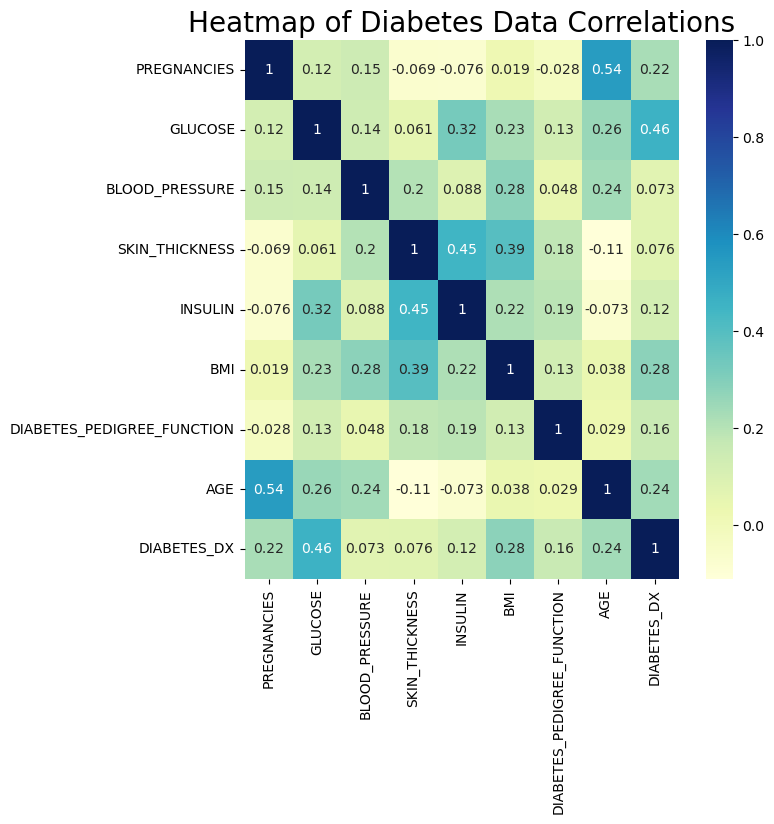

In [15]:
# Create a heatmap with the features
fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Heatmap of Diabetes Data Correlations', fontsize=20)
dataplot = sns.heatmap(df_correlation, cmap="YlGnBu", annot=True)

plt.show()

### Create `Pipeline` object
This standardizes feature engineering so that both training and inferencing will use the same transformations.

##### Shape dataframe 

In [16]:
# Drop fields with low predictive power
df_pipeline = df_hypertension.drop("ID").drop("BLOOD_PRESSURE").drop("DIABETES_DX")
df_pipeline.show()

df_pipeline.dtypes


----------------------------------------------------------------------------------------------------------------------------
|"PREGNANCIES"  |"GLUCOSE"  |"SKIN_THICKNESS"  |"INSULIN"  |"BMI"  |"DIABETES_PEDIGREE_FUNCTION"  |"AGE"  |"HYPERTENSION"  |
----------------------------------------------------------------------------------------------------------------------------
|6.0            |148.0      |35.0              |0.0        |33.6   |0.627                         |50.0   |NORMAL          |
|1.0            |85.0       |29.0              |0.0        |26.6   |0.351                         |31.0   |NORMAL          |
|8.0            |183.0      |0.0               |0.0        |23.3   |0.672                         |32.0   |NORMAL          |
|1.0            |89.0       |23.0              |94.0       |28.1   |0.167                         |21.0   |NORMAL          |
|0.0            |137.0      |35.0              |168.0      |43.1   |2.288                         |33.0   |NORMAL          |


[('PREGNANCIES', 'double'),
 ('GLUCOSE', 'double'),
 ('SKIN_THICKNESS', 'double'),
 ('INSULIN', 'double'),
 ('BMI', 'double'),
 ('DIABETES_PEDIGREE_FUNCTION', 'double'),
 ('AGE', 'double'),
 ('HYPERTENSION', 'string(15)')]

##### Categorize features

In [17]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["HYPERTENSION"]
CATEGORICAL_COLUMNS_OE = ["HYPERTENSION_OE"] # Used for labeling new OE column
NUMERICAL_COLUMNS = ["PREGNANCIES", "GLUCOSE", "SKIN_THICKNESS", "INSULIN", "BMI", "DIABETES_PEDIGREE_FUNCTION","AGE"]

categories = {
    "HYPERTENSION": np.array(["NORMAL", "PREHYPERTENSION", "HYPERTENSION"])
}

print(categories)

{'HYPERTENSION': array(['NORMAL', 'PREHYPERTENSION', 'HYPERTENSION'], dtype='<U15')}


##### Build pipeline

In [18]:
preprocessing_pipeline_diabetes = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(
                    input_cols = CATEGORICAL_COLUMNS,
                    output_cols = CATEGORICAL_COLUMNS_OE,
                    categories = categories,
                )
            ),
            (
                "MMS",
                snowml.MinMaxScaler(
                    clip = True,
                    input_cols = NUMERICAL_COLUMNS,
                    output_cols = NUMERICAL_COLUMNS,
                )
            )
    ]
)

PIPELINE_FILE_DIABETES = 'preprocessing_pipeline_diabetes.joblib'

##### Serialize pipeline

In [19]:
joblib.dump(preprocessing_pipeline_diabetes, PIPELINE_FILE_DIABETES) 

['preprocessing_pipeline_diabetes.joblib']

#### Apply to data  
Apply serialized pipeline to data, including `.fit()` and `.transform()`.
  
The .fit() method is used to compute any necessary statistics or parameters required for preprocessing.  
  
For example:  
  
 * In data preprocessing, .fit() might calculate the mean and standard deviation for scaling future data.  
 * In feature engineering, it might calculate the parameters needed for transformations like PCA.  
  
Once these parameters are calculated using the training data with .fit(), they are then applied to new, unseen data through methods like .transform(). This ensures that your pipeline processes new data consistently and accurately, based on what it has learned from the training data.  
  
**Let's go!**  

In [20]:
transformed_diabetes_df = preprocessing_pipeline_diabetes.fit(df_pipeline).transform(df_pipeline)
transformed_diabetes_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"PREGNANCIES"         |"GLUCOSE"           |"SKIN_THICKNESS"     |"INSULIN"            |"BMI"                |"DIABETES_PEDIGREE_FUNCTION"  |"AGE"                |"HYPERTENSION_OE"  |"HYPERTENSION"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.3529411764705882    |0.7437185929648241  |0.3181818181818182   |0.0                  |0.4168734491315137   |0.23441502988898377           |0.4833333333333334   |0.0                |NORMAL          |
|0.058823529411764705  |0.4271356783919598  |0.2636363636363636   |0.0                  |0.3300248138957817   |0.11656703672075149           |0.16666666666666663  |0.0                |NORMAL  

### Save serialized pipeline

 * Check that we're using the "GOLD" schema, as this is where DS_ASSETS staging was created
 * If not, then switch the schema being used in session to "GOLD"

In [21]:
# Save the serialized (pickled) object into stage "DS_ASSETS"
session.file.put(PIPELINE_FILE_DIABETES, "@DS_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline_diabetes.joblib', target='preprocessing_pipeline_diabetes.joblib.gz', source_size=1744, target_size=1040, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

# 5. ML Modeling

- Train a logit model using Snowpark ML Package
  - Makes sense because we want to produce a binary prediction (yes or no diabetes)
- Train a random forest classifier using Snowpark ML Package
  - Makes sense because we have a mixture of categorical and continuous variables, which typically is handled well by tree-based models.
- Deploy the model to Snowflake Model Registry (stored in staging) and call for inferences.

#### GET DATA

In [22]:
# Get data
databaseName = 'DEMO_DATASCIENCE'
schemaName = 'GOLD'
tableName = 'DIABETES_DS'

location = f'{databaseName}.{schemaName}.{tableName}'

df_ds = session.table(location)

df_ds.show()
df_ds.dtypes

--------------------------------------------------------------------------------------------------------------------------------------------
|"PREGNANCIES"  |"GLUCOSE"  |"HYPERTENSION"  |"SKIN_THICKNESS"  |"INSULIN"  |"BMI"  |"DIABETES_PEDIGREE_FUNCTION"  |"AGE"  |"DIABETES_DX"  |
--------------------------------------------------------------------------------------------------------------------------------------------
|6.0            |148.0      |NORMAL          |35.0              |0.0        |33.6   |0.627                         |50.0   |1.0            |
|1.0            |85.0       |NORMAL          |29.0              |0.0        |26.6   |0.351                         |31.0   |0.0            |
|8.0            |183.0      |NORMAL          |0.0               |0.0        |23.3   |0.672                         |32.0   |1.0            |
|1.0            |89.0       |NORMAL          |23.0              |94.0       |28.1   |0.167                         |21.0   |0.0            |
|0.0         

[('PREGNANCIES', 'double'),
 ('GLUCOSE', 'double'),
 ('HYPERTENSION', 'string(15)'),
 ('SKIN_THICKNESS', 'double'),
 ('INSULIN', 'double'),
 ('BMI', 'double'),
 ('DIABETES_PEDIGREE_FUNCTION', 'double'),
 ('AGE', 'double'),
 ('DIABETES_DX', 'double')]

#### Get `Pipeline` Ready

In [23]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["HYPERTENSION"]
CATEGORICAL_COLUMNS_OE = ["HYPERTENSION_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["PREGNANCIES", "GLUCOSE", "SKIN_THICKNESS", "INSULIN", "BMI", "DIABETES_PEDIGREE_FUNCTION","AGE"]

LABEL_COLUMNS = ['DIABETES_DX']

In [24]:
# Load the preprocessing pipeline object
PIPELINE_FILE = 'preprocessing_pipeline_diabetes.joblib'
preprocessing_pipeline = joblib.load(PIPELINE_FILE)

### Create Train/Test Split

In [25]:
# Split the data into train and test sets
diabetes_train_df, diabetes_test_df = df_ds.random_split(weights = [0.7, 0.3], seed = 23)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.\
            fit(diabetes_train_df).\
            transform(diabetes_train_df)

test_df = preprocessing_pipeline.transform(diabetes_test_df)

#### Persist Train/Test Data in Snowflake  
Save train and test subsets in Snowflake. Makes for easy access.  
Can use this syntax to retrieve:  
  
`train_df = session.table('DEMO_DATASCIENCE.GOLD.DIABETES_TRAIN_DF')`  
`test_df = session.table('DEMO_DATASCIENCE.GOLD.DIABETES_TEST_DF')`

In [26]:
train_df.write.save_as_table(table_name='DIABETES_TRAIN_DF', mode='overwrite')
test_df.write.save_as_table(table_name='DIABETES_TEST_DF', mode='overwrite')

### Build Simple Logit Model

What's happening here? 

- The `model.fit()` function creates a temp stored procedure in the background. 
- Be sure to use a [Snowpark Optimized Warehouse](https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized) **ONLY** if you need more memory. This is **NOT** to be used for all ML processes.  
- The `model.predict()` function creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames
- Inference is parallelized across all batches.  
  
What's **NOT** happening here? 
- Building a finely tuned ML model worthy of winning a Kaggle competition

Build model. Compute is pushed down to Snowflake.

In [27]:
# Define the Classifier
logit_basic = LR(max_iter = 100, #Default is 100 iterations
                 random_state = 23,
                 penalty = 'none',
                 input_cols = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS,
                 label_cols = LABEL_COLUMNS,
                 output_cols = ['PREDICTED_DIABETES_DX']
                )

# Train on train_df data
logit_basic.fit(train_df)

#### Test Basic Logit Model  
Scoring on test dataset.  
We can compare the actual outcome to the machine's predicted outcome.  
Scoring computation is pushed down into Snowflake.  

In [28]:
scored_logit_basic = logit_basic.predict(test_df)

scored_logit_basic.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"HYPERTENSION_OE"  |"GLUCOSE"            |"BMI"                |"HYPERTENSION"   |"DIABETES_PEDIGREE_FUNCTION"  |"SKIN_THICKNESS"     |"PREGNANCIES"         |"INSULIN"            |"AGE"                |"DIABETES_DX"  |"PREDICTED_DIABETES_DX"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.0                |0.7437185929648241   |0.4168734491315137   |NORMAL           |0.23441502988898377           |0.3181818181818182   |0.3529411764705882    |0.0                  |0.4833333333333334   |1.0            |1.0                      |
|0.0            

In [29]:
# Bumping up horsepower, otherwise it will take 1.0 minutes to run on small compute.
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=XLARGE;").collect()

[Row(status='Statement executed successfully.')]

Acccuracy: 0.765258
Precision: 0.7416267942583732


DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.5149501661129569
F1: 0.607843137254902


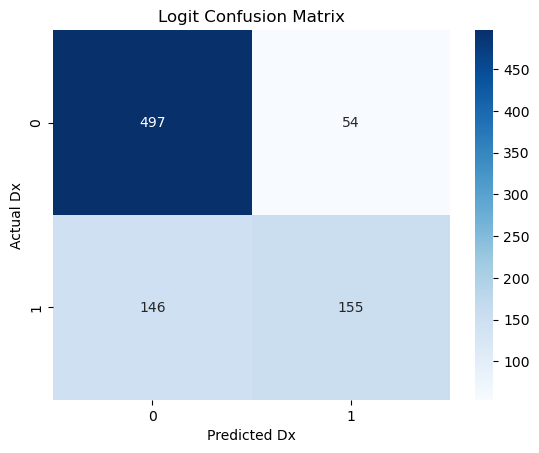

In [30]:
cf_matrix = CM(df = scored_logit_basic, 
               y_true_col_name = 'DIABETES_DX', 
               y_pred_col_name = 'PREDICTED_DIABETES_DX')

sns.heatmap(data = cf_matrix, annot = True, fmt = 'g', cmap = 'Blues')

plt.xlabel('Predicted Dx')
plt.ylabel('Actual Dx')
plt.title('Logit Confusion Matrix')

print('Acccuracy:', M.accuracy_score(df = scored_logit_basic, 
                                     y_true_col_names='DIABETES_DX', 
                                     y_pred_col_names='PREDICTED_DIABETES_DX'))

print('Precision:', M.precision_score(df = scored_logit_basic, 
                                      y_true_col_names='DIABETES_DX', 
                                      y_pred_col_names='PREDICTED_DIABETES_DX'))

print('Recall:', M.recall_score(df = scored_logit_basic, 
                                y_true_col_names='DIABETES_DX', 
                                y_pred_col_names='PREDICTED_DIABETES_DX'))

print('F1:', M.f1_score(df = scored_logit_basic, 
                        y_true_col_names='DIABETES_DX', 
                        y_pred_col_names='PREDICTED_DIABETES_DX'))

In [31]:
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=SMALL;").collect()

[Row(status='Statement executed successfully.')]

In [32]:
#df_check = scored_logit_basic.select(F.col("DIABETES_DX"), F.col("PREDICTED_DIABETES_DX")).to_pandas()
#df_check['Gut_Check'] = np.where((df_check['DIABETES_DX'] == 1) & (df_check['PREDICTED_DIABETES_DX'] == 1), 'True Positive',
#                        np.where((df_check['DIABETES_DX'] == 0) & (df_check['PREDICTED_DIABETES_DX'] == 0), 'True Negative',
#                        np.where((df_check['DIABETES_DX'] == 1) & (df_check['PREDICTED_DIABETES_DX'] == 0), 'False Negative',
#                        np.where((df_check['DIABETES_DX'] == 0) & (df_check['PREDICTED_DIABETES_DX'] == 1), 'False Positive',
#                                 'ERROR'
#                                 ))))
#df_check['Gut_Check'].value_counts()

In [33]:
#SCIKIT_CM(df_check['DIABETES_DX'], df_check['PREDICTED_DIABETES_DX'])

### Build Better Logit Model

<Axes: >

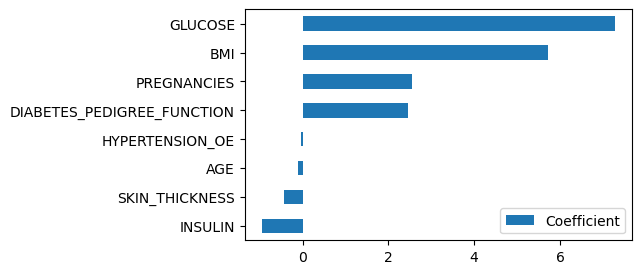

In [34]:
# Check feature coefficients here to see which variables had greatest impact.
lm_local = logit_basic.to_sklearn()
feature_coefficients = pd.DataFrame(lm_local.coef_.T, lm_local.feature_names_in_, columns=['Coefficient'])
feature_coefficients.sort_values('Coefficient').plot.barh(y='Coefficient', figsize=(5,3))

#### Logit with Regularization

**Lasso (l1) regularization**  
Feature selection, ie may penalize coefficients to zero

In [35]:
#lbfgs only works for ridge regularization. This should error out.

logit_lasso = LR(max_iter = 1000, #Default is 100 iterations
                 random_state = 23,
                 penalty = 'l1',
                 C=1.0,  #smaller values specify stronger regularization
                 solver='lbfgs', 
                 input_cols = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS,
                 label_cols = LABEL_COLUMNS,
                 output_cols = ['PREDICTED_DIABETES_DX']
                )

logit_lasso.fit(train_df)

SnowparkSQLException: (1300) (1304): 01b4875d-0b06-49ee-0003-789200302b36: 100357 (P0000): Python Interpreter Error:
Traceback (most recent call last):
  File "_udf_code.py", line 77, in compute
  File "/Users/vchung/anaconda3/envs/snowflake_ds/lib/python3.10/site-packages/snowflake/ml/modeling/_internal/snowpark_trainer.py", line 226, in fit_wrapper_function
  File "/usr/lib/python_udf/2a5f6b3994c4047ec3fe27f98a354efb361b5af2f72a8f3eb7234989dd3a7978/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/lib/python_udf/2a5f6b3994c4047ec3fe27f98a354efb361b5af2f72a8f3eb7234989dd3a7978/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
 in function SNOWPARK_TEMP_PROCEDURE_7533ZR9GPX with handler compute

In [36]:
logit_lasso = LR(max_iter = 1000, #Default is 100 iterations
                 random_state = 23,
                 penalty = 'l1', 
                 C=1.0,  #smaller values specify stronger regularization
                 solver='liblinear', #1st order optimization.
                 input_cols = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS,
                 label_cols = LABEL_COLUMNS,
                 output_cols = ['PREDICTED_DIABETES_DX']
                )

logit_lasso.fit(train_df)

**Ridge (l2) Regularization**  
No feature selection. Minimizes but doesn't zero out the variable.

In [37]:
logit_ridge = LR(max_iter = 1000, #Default is 100 iterations
                 random_state = 23,
                 penalty = 'l2', 
                 C=1.0,  #smaller values specify stronger regularization
                 solver = 'lbfgs', #2nd order optimization. If memory is not a concern, LBFGS might provide better performance due to its faster convergence and potentially higher accuracy vs liblinear.
                 input_cols = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS,
                 label_cols = LABEL_COLUMNS,
                 output_cols = ['PREDICTED_DIABETES_DX']
                )

logit_ridge.fit(train_df)

#### Test Penalized Logit

In [38]:
scored_logit_lasso = logit_lasso.predict(test_df)
scored_logit_ridge = logit_ridge.predict(test_df)

Acccuracy: 0.762911


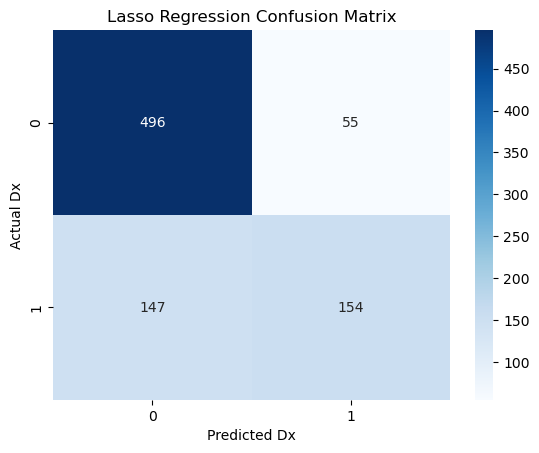

In [39]:
cf_matrix = CM(df = scored_logit_lasso, 
               y_true_col_name = 'DIABETES_DX', 
               y_pred_col_name = 'PREDICTED_DIABETES_DX')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

plt.xlabel('Predicted Dx')
plt.ylabel('Actual Dx')
plt.title('Lasso Regression Confusion Matrix')

print('Acccuracy:', M.accuracy_score(df = scored_logit_lasso, 
                                     y_true_col_names='DIABETES_DX', 
                                     y_pred_col_names='PREDICTED_DIABETES_DX'))

Acccuracy: 0.762911


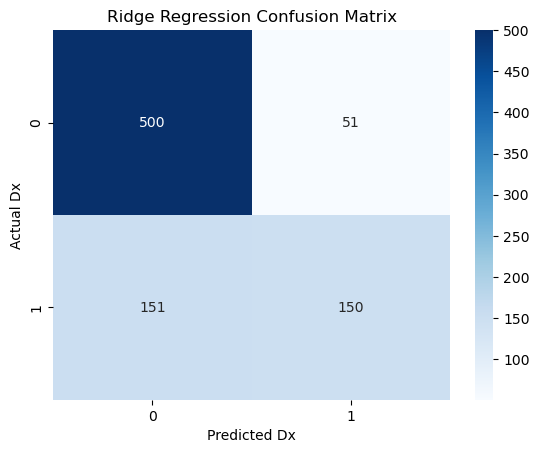

In [40]:
cf_matrix = CM(df = scored_logit_ridge, 
               y_true_col_name = 'DIABETES_DX', 
               y_pred_col_name = 'PREDICTED_DIABETES_DX')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

plt.xlabel('Predicted Dx')
plt.ylabel('Actual Dx')
plt.title('Ridge Regression Confusion Matrix')

print('Acccuracy:', M.accuracy_score(df = scored_logit_ridge, 
                                     y_true_col_names='DIABETES_DX', 
                                     y_pred_col_names='PREDICTED_DIABETES_DX'))

### Build Tree-based Models

#### Create & Fit Model

In [41]:
RF_basic = RF(n_estimators = 1000, 
              random_state = 23,
              n_jobs = -1,
              max_depth = None,
              criterion = 'entropy', # gini is computationally faster, but I want to show pushing the engine
              min_samples_split = 2,
              
              input_cols = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS,
              label_cols = LABEL_COLUMNS,
              output_cols = ['PREDICTED_DIABETES_DX']
                )

XGB_basic = XGB(n_estimators = 1000, 
                random_state = 23,
                n_jobs = -1,
              
              input_cols = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS,
              label_cols = LABEL_COLUMNS,
              output_cols = ['PREDICTED_DIABETES_DX']
                )

RF_basic.fit(train_df)
XGB_basic.fit(train_df)

#### Test Models

In [42]:
scored_RF_basic = RF_basic.predict(test_df)
scored_XGB_basic = XGB_basic.predict(test_df)

Acccuracy: 0.991784


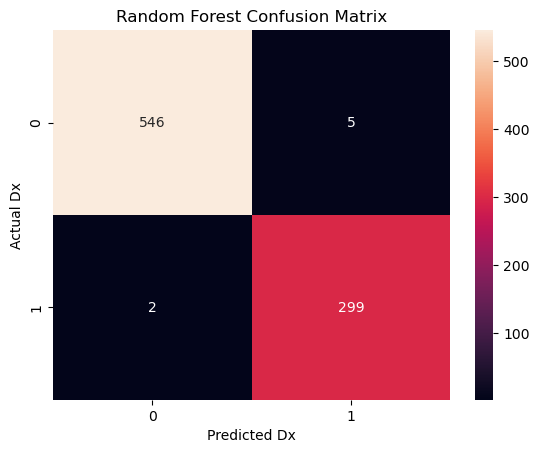

In [43]:
cf_matrix = CM(df = scored_RF_basic, 
               y_true_col_name = 'DIABETES_DX', 
               y_pred_col_name = 'PREDICTED_DIABETES_DX')

sns.heatmap(cf_matrix, annot=True, fmt='g')

plt.xlabel('Predicted Dx')
plt.ylabel('Actual Dx')
plt.title('Random Forest Confusion Matrix')

print('Acccuracy:', M.accuracy_score(df = scored_RF_basic, 
                                     y_true_col_names='DIABETES_DX', 
                                     y_pred_col_names='PREDICTED_DIABETES_DX'))

Acccuracy: 0.987089


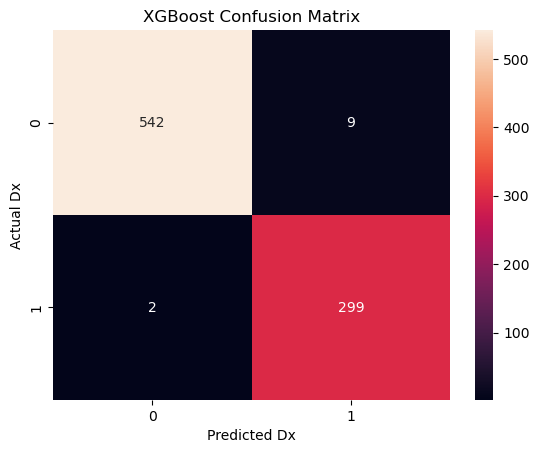

In [44]:
cf_matrix = CM(df = scored_XGB_basic, 
               y_true_col_name = 'DIABETES_DX', 
               y_pred_col_name = 'PREDICTED_DIABETES_DX')

sns.heatmap(cf_matrix, annot=True, fmt='g')

plt.xlabel('Predicted Dx')
plt.ylabel('Actual Dx')
plt.title('XGBoost Confusion Matrix')

print('Acccuracy:', M.accuracy_score(df = scored_XGB_basic, 
                                     y_true_col_names='DIABETES_DX', 
                                     y_pred_col_names='PREDICTED_DIABETES_DX'))

# 6. Model Deployment

Snowpark ML's `model.predict()` function creates a ***temporary*** UDF, we'll need to define our own UDF to persist as permanent UDF. 

Save model as sklearn object so it can be used externally.

#### Serialize & Save in Staging

In [ ]:
# Save RF Tuned model 
xgb_model = XGB_basic.to_xgboost()
MODEL_FILE = 'XGBmodel.joblib'
joblib.dump(xgb_model, MODEL_FILE) # we are just pickling it locally first

# upload into the DS_ASSETS stage in Snowflake
session.file.put(MODEL_FILE, "@DS_ASSETS", overwrite=True)



In [ ]:
# Model is now visible in staging: Can see this by quering "List @DS_ASSETS" to show model loaded to stage
session.sql("list @DS_ASSETS").show()

In [ ]:
# Get all relevant column names to pass into the UDF call
feature_cols = test_df[CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS].columns
feature_cols


#### Create UDF

In [ ]:
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import os
    import sys
    import joblib

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_diabetes', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@DS_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@DS_ASSETS/XGBmodel.joblib.gz'],
     packages=['pandas','joblib','cachetools','xgboost'])
def batch_predict_diabetes(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = ['HYPERTENSION_OE', 'PREGNANCIES', 'GLUCOSE', 'SKIN_THICKNESS', 'INSULIN', 'BMI', 'DIABETES_PEDIGREE_FUNCTION', 'AGE']
    model = load_model('XGBmodel.joblib.gz')
    return model.predict(test_df) 
        


#### Call UDF

In [ ]:
test = test_df.with_column('PREDICTION', batch_predict_diabetes(*feature_cols))
test.show()

Go to snowsight and demo UDF

In [ ]:
session.close()